In [1]:
import recordlinkage as rl
from recordlinkage.datasets import load_febrl1, load_febrl2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# Actividad 1

In [15]:
dataset1 = pd.read_csv('/Users/nestorivanmo/Desktop/iimas-data-science/spring-21/calprep/practicas/3/dataset1.csv')
dataset1.rename(str.strip, axis='columns', inplace=True)
dataset1.head()

,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
0,rec-223-org,,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
1,rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
2,rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
3,rec-10-dup-0,kayla,harrington,,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
4,rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933


In [2]:
febrl1, febrl1_true_links =  load_febrl1(True)
febrl1.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-223-org,NaN,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933


In [3]:
def asignar_indices(a, verdaderos_links): # a = dataset1.rec_id.unique()
    dic = dict(zip(a, np.arange(len(a))))
    df = verdaderos_links.to_frame()
    df.rename(str, axis='columns', inplace=True)
    df["0"] = df["0"].apply(dic.get)
    df["1"] = df["1"].apply(dic.get)
    true_values = pd.MultiIndex.from_frame(df)
    return true_values

In [17]:
true_values = asignar_indices(febrl1.index.unique(), febrl1_true_links)
true_values

MultiIndex([(474,   0),
            (330,   1),
            (351,   2),
            (290,   3),
            (333,   4),
            (591,   5),
            (150,   6),
            (377,   7),
            (836,   8),
            ( 14,   9),
            ...
            (877, 852),
            (908, 857),
            (986, 858),
            (863, 861),
            (955, 866),
            (895, 886),
            (987, 906),
            (921, 909),
            (943, 942),
            (953, 946)],
           names=['0', '1'], length=500)

In [18]:
def block_index_(dataset):
    print(dataset.head())
    indexer = rl.Index()
    indexer.block('given_name')
    indexer.block('surname')
    indexer.block('suburb')
    indexer.block('postcode')
    indexer.block('date_of_birth')
    indexer.block('soc_sec_id')
    compare_indices = indexer.index(dataset)
    return compare_indices

def sorted_neighbourhood_index_(dataset, window=3):
    indexer = rl.Index()
    indexer.sortedneighbourhood('given_name', window=window)
    indexer.sortedneighbourhood('surname', window=window)
    indexer.sortedneighbourhood('suburb', window=window)
    indexer.sortedneighbourhood('postcode', window=window)
    indexer.sortedneighbourhood('date_of_birth', window=window)
    indexer.sortedneighbourhood('soc_sec_id', window=window)
    return indexer.index(dataset)
    
def compare_(dataset, compare_indices, method):
    comp = rl.Compare()
    comp.string('given_name', 'given_name', label='given_name', method=method)
    comp.string('surname', 'surname', label='surname', method=method)
    comp.string('suburb', 'suburb', label='suburb', method=method)
    comp.string('date_of_birth', 'date_of_birth', label='date_of_birth', method=method)
    comp.numeric('postcode', 'postcode', label='postcode')
    comp.numeric('soc_sec_id', 'soc_sec_id', label='soc_sec_id')
    features = comp.compute(compare_indices, dataset)
    return features

In [25]:
def modelos(dataset, verdaderos_links):
    ses = 0
    m = None
    f_idx = None
    f_cmp = None
    for indexado in indexados:
        for comparador in comparadores:
            for clasificador in clasificadores:
                print("Indexado: %s\nComparador: %s\nClasificador: %s" % (indexado.__name__, comparador, clasificador.__name__))
                idx = indexado(dataset)
                caracteristicas = compare_(dataset, compare_indices=idx, method=comparador)
                train, test = train_test_split(caracteristicas, test_size=0.25)

                matches_train = train.index & verdaderos_links
                matches_test = test.index & verdaderos_links
                
                clas = clasificador()
                
                clas.fit(caracteristicas, matches_train)
                
                predicciones = clas.predict(test)
                confusion_matrix = rl.confusion_matrix(matches_test, predicciones, len(test))
                sns.heatmap(confusion_matrix, annot=True, fmt="d")
                plt.show()
                
                precision = rl.precision(confusion_matrix)
                sensibilidad = rl.recall(confusion_matrix)
                f_score = rl.fscore(confusion_matrix)
                
                if ses < f_score:
                    ses = f_score
                    m = clas
                    f_idx = indexado
                    f_cmp = comparador
                    
                print("Precision:", precision)
                print("Sensibilidad:", sensibilidad)
                print("F-Score:", f_score, "\n")
    return m, f_idx, f_cmp

In [26]:
indexados = [block_index_, sorted_neighbourhood_index_]
comparadores = ["jaro", "qgram", "levenshtein"]
clasificadores = [rl.SVMClassifier, rl.LogisticRegressionClassifier]#, rl.NaiveBayesClassifier]

Indexado: block_index_
Comparador: jaro
Clasificador: SVMClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani      garbutt      2260   vic      19831024     8099933  
<ipython-input-25-aa71b0ca33cc>:14: FutureW

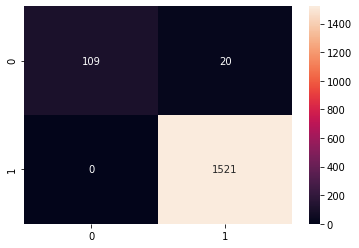

Precision: 1.0
Sensibilidad: 0.8449612403100775
F-Score: 0.9159663865546218 

Indexado: block_index_
Comparador: jaro
Clasificador: LogisticRegressionClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani      ga

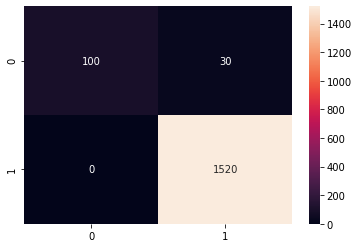

Precision: 1.0
Sensibilidad: 0.7692307692307693
F-Score: 0.8695652173913044 

Indexado: block_index_
Comparador: qgram
Clasificador: SVMClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani      garbutt      226

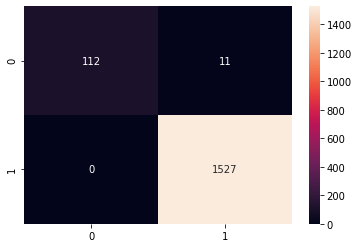

Precision: 1.0
Sensibilidad: 0.9105691056910569
F-Score: 0.9531914893617021 

Indexado: block_index_
Comparador: qgram
Clasificador: LogisticRegressionClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani      g

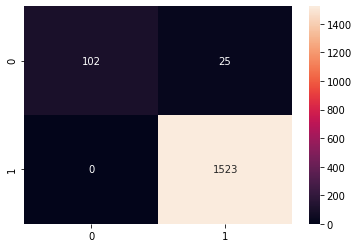

Precision: 1.0
Sensibilidad: 0.8031496062992126
F-Score: 0.8908296943231442 

Indexado: block_index_
Comparador: levenshtein
Clasificador: SVMClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani      garbutt   

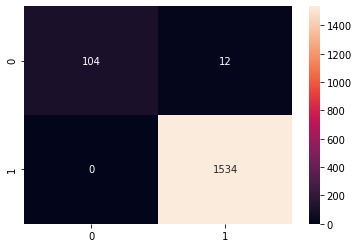

Precision: 1.0
Sensibilidad: 0.896551724137931
F-Score: 0.9454545454545454 

Indexado: block_index_
Comparador: levenshtein
Clasificador: LogisticRegressionClassifier
         rec_id given_name      surname street_number           address_1  \
0   rec-223-org                  waller             6    tullaroop street   
1   rec-122-org    lachlan        berry            69       giblin street   
2   rec-373-org     deakin   sondergeld            48   goldfinch circuit   
3  rec-10-dup-0      kayla   harrington                    maltby circuit   
4   rec-227-org       luke       purdon            23        ramsay place   

    address_2       suburb  postcode state date_of_birth  soc_sec_id  
0    willaroo     st james      4011    wa      19081209     6988048  
1   killarney      bittern      4814   qld      19990219     7364009  
2     kooltuo   canterbury      2776   vic      19600210     2635962  
3     coaling     coolaroo      3465   nsw      19150612     9004242  
4      mirani  

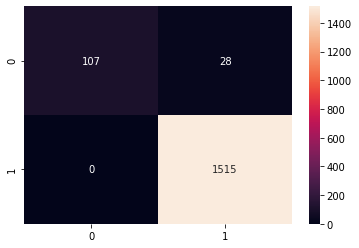

Precision: 1.0
Sensibilidad: 0.7925925925925926
F-Score: 0.884297520661157 

Indexado: sorted_neighbourhood_index_
Comparador: jaro
Clasificador: SVMClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & comparison_vectors.index] = 1
/u

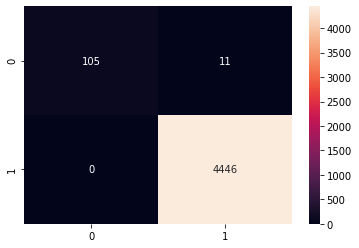

Precision: 1.0
Sensibilidad: 0.9051724137931034
F-Score: 0.9502262443438914 

Indexado: sorted_neighbourhood_index_
Comparador: jaro
Clasificador: LogisticRegressionClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & comparison_vecto

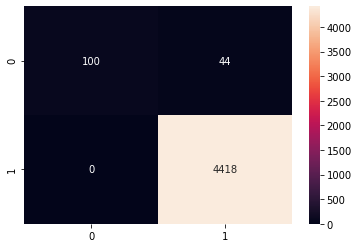

Precision: 1.0
Sensibilidad: 0.6944444444444444
F-Score: 0.819672131147541 

Indexado: sorted_neighbourhood_index_
Comparador: qgram
Clasificador: SVMClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & comparison_vectors.index] = 1
/

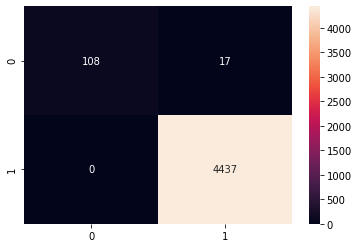

Precision: 1.0
Sensibilidad: 0.864
F-Score: 0.9270386266094421 

Indexado: sorted_neighbourhood_index_
Comparador: qgram
Clasificador: LogisticRegressionClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & comparison_vectors.index] = 

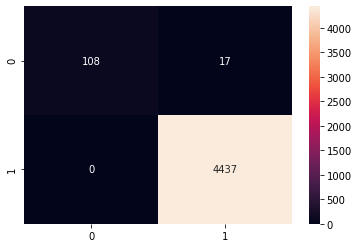

Precision: 1.0
Sensibilidad: 0.864
F-Score: 0.9270386266094421 

Indexado: sorted_neighbourhood_index_
Comparador: levenshtein
Clasificador: SVMClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & comparison_vectors.index] = 1
/usr/lo

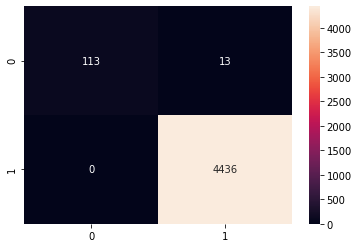

Precision: 1.0
Sensibilidad: 0.8968253968253969
F-Score: 0.9456066945606695 

Indexado: sorted_neighbourhood_index_
Comparador: levenshtein
Clasificador: LogisticRegressionClassifier
<ipython-input-25-aa71b0ca33cc>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_train = train.index & verdaderos_links
<ipython-input-25-aa71b0ca33cc>:15: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches_test = test.index & verdaderos_links
/usr/local/lib/python3.9/site-packages/recordlinkage/base.py:950: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  y.loc[match_index & compariso

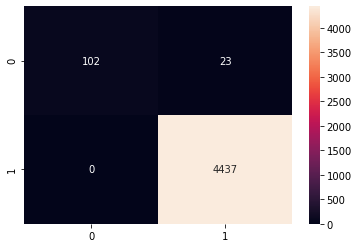

Precision: 1.0
Sensibilidad: 0.816
F-Score: 0.8986784140969163 



In [27]:
 modelo, f_idx, f_cmp = modelos(dataset1, true_values)

# Actividad 2

In [28]:
dataset2 = pd.read_csv('~/Desktop/iimas-data-science/spring-21/calprep/practicas/3/dataset2.csv')
dataset2.rename(str.strip, axis='columns', inplace=True)
dataset2.head()

,rec_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
0,rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
1,rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
2,rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
3,rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
4,rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742


In [29]:
febrl2, febrl2_true_links =  rl.datasets.load_febrl2(True)
true_values2 = asignar_indices(febrl2.index.unique(), febrl2_true_links)

In [31]:
idx = f_idx(dataset2)
caracteristicas = compare_(dataset2, compare_indices=idx, method=f_cmp)

          rec_id given_name     surname street_number          address_1  \
0   rec-2778-org      sarah       bruhn            44      forbes street   
1  rec-712-dup-0      jacob      lanyon             5         milne cove   
2   rec-1321-org    brinley   efthimiou            35   sturdee crescent   
3   rec-3004-org    aleisha      hobson            54      oliver street   
4   rec-1384-org      ethan     gazzola            49     sheaffe street   

     address_2               suburb  postcode state date_of_birth  soc_sec_id  
0   wintersloe         kellerberrin      4510   vic      19300213     7535316  
1      wellwod   beaconsfield upper      2602   vic      19080712     9497788  
2    tremearne          scarborough      5211   qld      19940319     6814956  
3    inglewood            toowoomba      3175   qld      19290427     5967384  
4   bimby vale           port pirie      3088    sa      19631225     3832742  


In [32]:
matches = caracteristicas.index & true_values2

<ipython-input-32-9f4df952283b>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  matches = caracteristicas.index & true_values2


/usr/local/lib/python3.9/site-packages/recordlinkage/measures.py:147: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return len(links_true & links_pred)
/usr/local/lib/python3.9/site-packages/recordlinkage/measures.py:179: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return int(total) - len(links_true | links_pred)


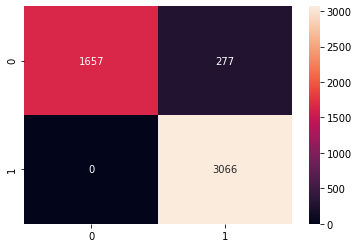

Precision: 1.0
Sensibilidad: 0.8567735263702172
F-Score: 0.9228627123363966 



In [35]:
predicciones = modelo.predict(caracteristicas)
confusion_matrix = rl.confusion_matrix(matches, predicciones, len(febrl2))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()

precision = rl.precision(confusion_matrix)
sensibilidad = rl.recall(confusion_matrix)
f_score = rl.fscore(confusion_matrix)
#modelo.append((f_score, precision, sensibilidad, (caracteristicas.index, clas)))
print("Precision:", precision)
print("Sensibilidad:", sensibilidad)
print("F-Score:", f_score, "\n")